In [22]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
pd.set_option("display.max_columns", None)

In [24]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.shape

(2579, 83)

In [25]:
# Define y as "SalePrice"
y = data.SalePrice.copy()

## Quick look at <span style="color:darkred">Sales Prices</span> 💵

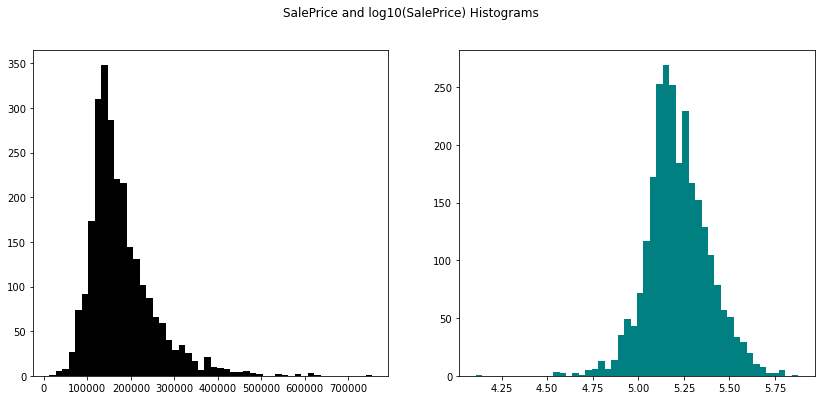

In [26]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

## 🤦‍♂️ David's: 
### GarageCars, BsmtQual

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

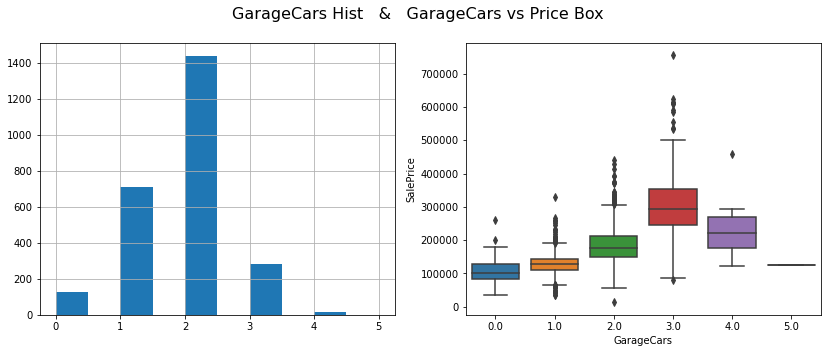

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('GarageCars Hist   &   GarageCars vs Price Box', size=16)

data['GarageCars'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['GarageCars'],y=y)

### <span style="color:Teal">Combine 4 & 5 into 3, and fill NaN with 0</span>

In [28]:
data['GarageCars'].replace({np.NaN:0,4:3,5:3}, inplace=True)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

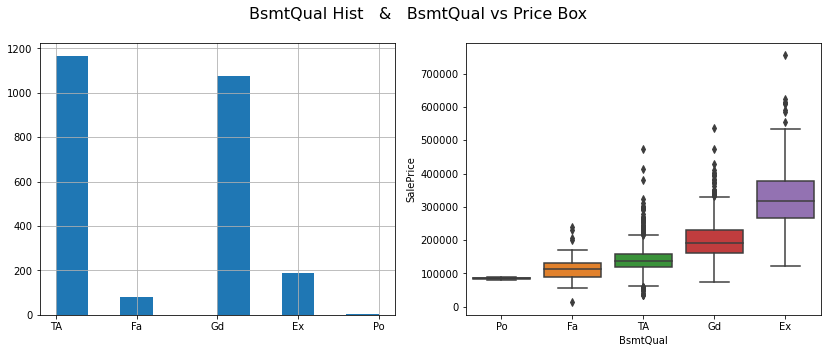

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('BsmtQual Hist   &   BsmtQual vs Price Box', size=16)

data['BsmtQual'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['BsmtQual'],y=y,order=['Po','Fa','TA','Gd','Ex'])

## 🤷‍♂️ Karl's: 
### Foundation, PavedDrive, BsmtFullBath + BsmtHalfBath + FullBath + HalfBath, BedroomAbvGr, TotRmsAbvGrd

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

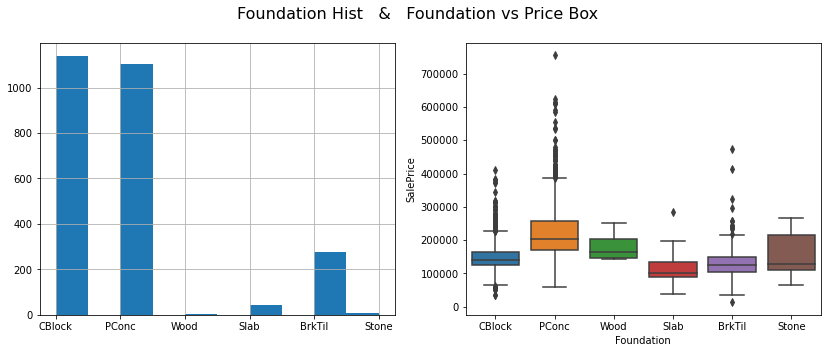

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Foundation Hist   &   Foundation vs Price Box', size=16)

data['Foundation'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Foundation'],y=y)

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

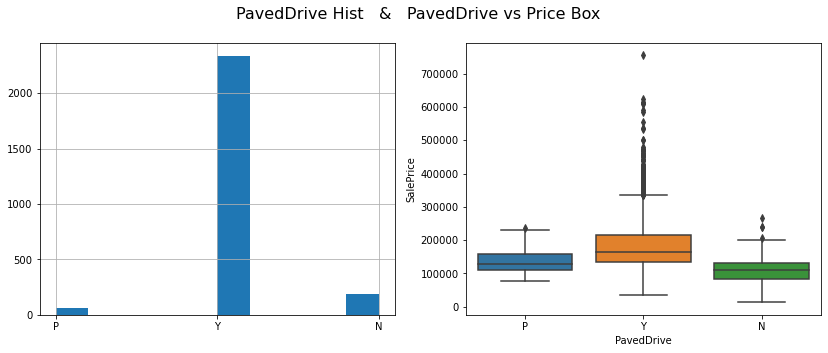

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('PavedDrive Hist   &   PavedDrive vs Price Box', size=16)

data['PavedDrive'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['PavedDrive'],y=y)

### 🐦NewFeat: <span style="color:Red">AllBath</span>  (fill NaN with 0)
* = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath (Full = 1, Half = 0.5)

In [57]:
data['AllBath'] = data.BsmtFullBath + data.BsmtHalfBath/2 + data.FullBath + data.HalfBath/2
data['AllBath'].replace({np.NaN:0}, inplace=True)

<AxesSubplot:xlabel='AllBath', ylabel='SalePrice'>

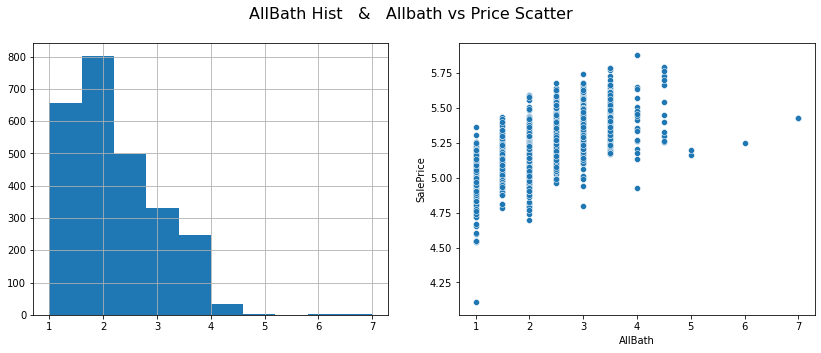

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('AllBath Hist   &   Allbath vs Price Scatter', size=16)

data['AllBath'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['AllBath'],y=np.log10(y))

### TotalBedrooms vs TotalAllRooms

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

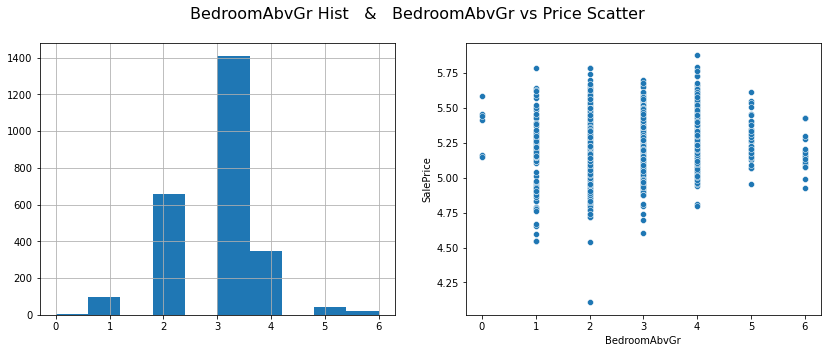

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('BedroomAbvGr Hist   &   BedroomAbvGr vs Price Scatter', size=16)

data['BedroomAbvGr'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['BedroomAbvGr'],y=np.log10(y))

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

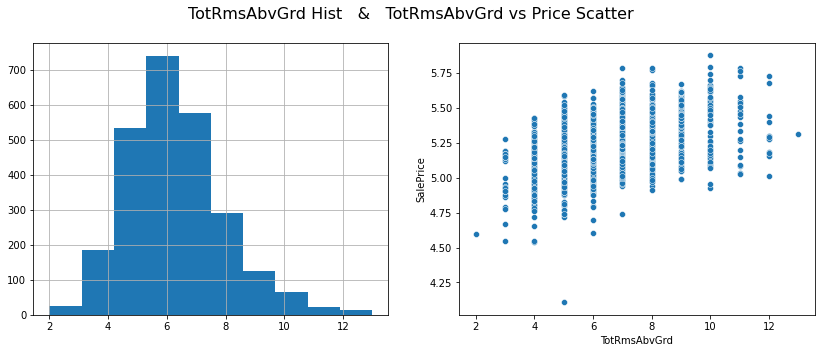

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('TotRmsAbvGrd Hist   &   TotRmsAbvGrd vs Price Scatter', size=16)

data['TotRmsAbvGrd'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['TotRmsAbvGrd'],y=np.log10(y))

## Total Rooms maybe better than only Bedrooms

## 🧏‍♂️ Tony's
### Fireplaces, HeatingQC

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

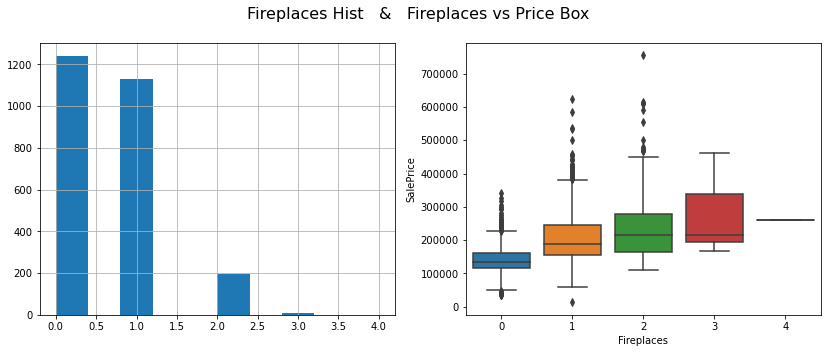

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Fireplaces Hist   &   Fireplaces vs Price Box', size=16)

data['Fireplaces'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Fireplaces'],y=y)

### <span style="color:Teal">Combine 3 & 4 into 2, and fill NaN with 0</span>

In [38]:
data['Fireplaces'].replace({np.NaN:0,3:2,4:2}, inplace=True)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

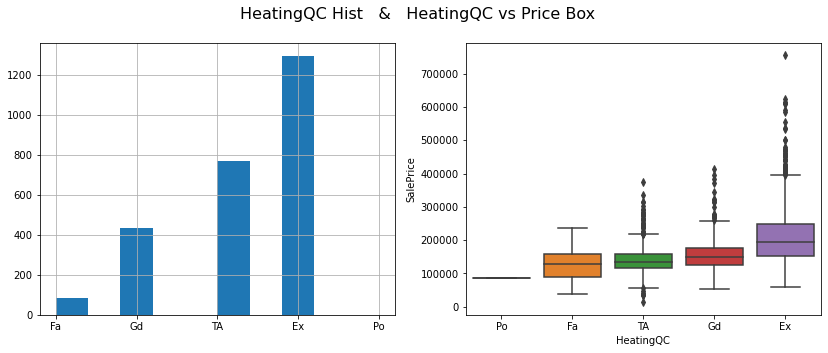

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('HeatingQC Hist   &   HeatingQC vs Price Box', size=16)

data['HeatingQC'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['HeatingQC'],y=y, order=['Po','Fa','TA','Gd','Ex'])

## 👴 Daniel's
### Neighborhood, YearBuilt, OverallQual,

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

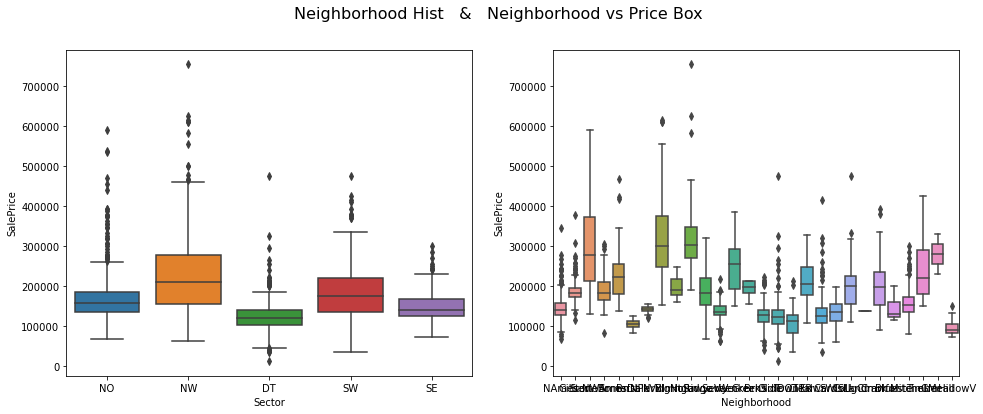

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Neighborhood Hist   &   Neighborhood vs Price Box', size=16)

sns.boxplot(ax=ax1, x=data['Sector'],y=y)
sns.boxplot(ax=ax2, x=data['Neighborhood'],y=y)

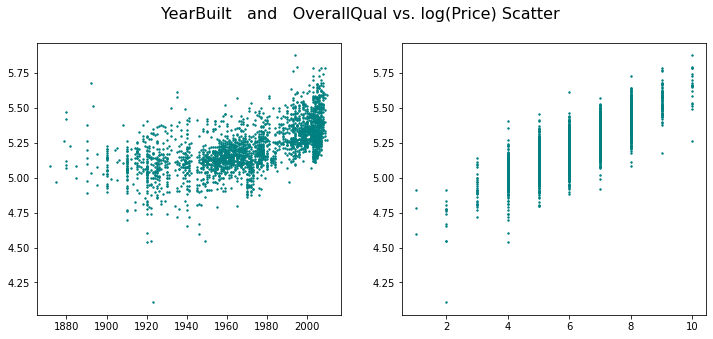

In [48]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   OverallQual vs. log(Price) Scatter', size=16)

ax1.scatter(x=data.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=data.OverallQual,y=np.log10(y),s=2,c='teal')

## <span style="color:darkred">Size Related</span> Features 📐 (continuous)
* Columns with "SF" / "AREA" / "Porch Size"

In [44]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

### 🐦New Feat <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [45]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [46]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

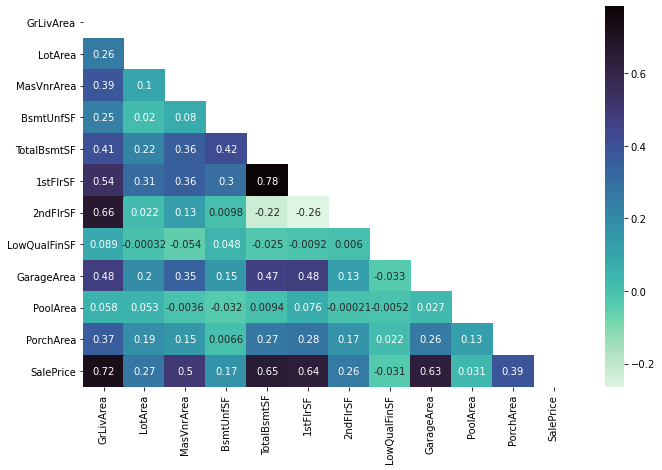

In [53]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

#### Investigate GrLivArea (largest correlation with Sale Price 0.72)

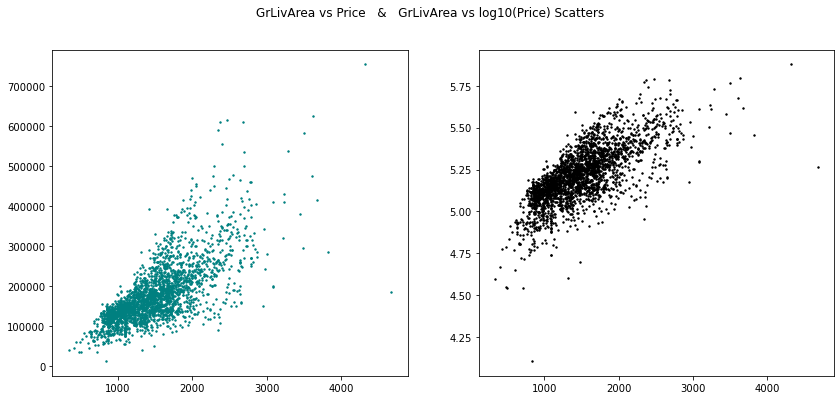

In [54]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

### All Others

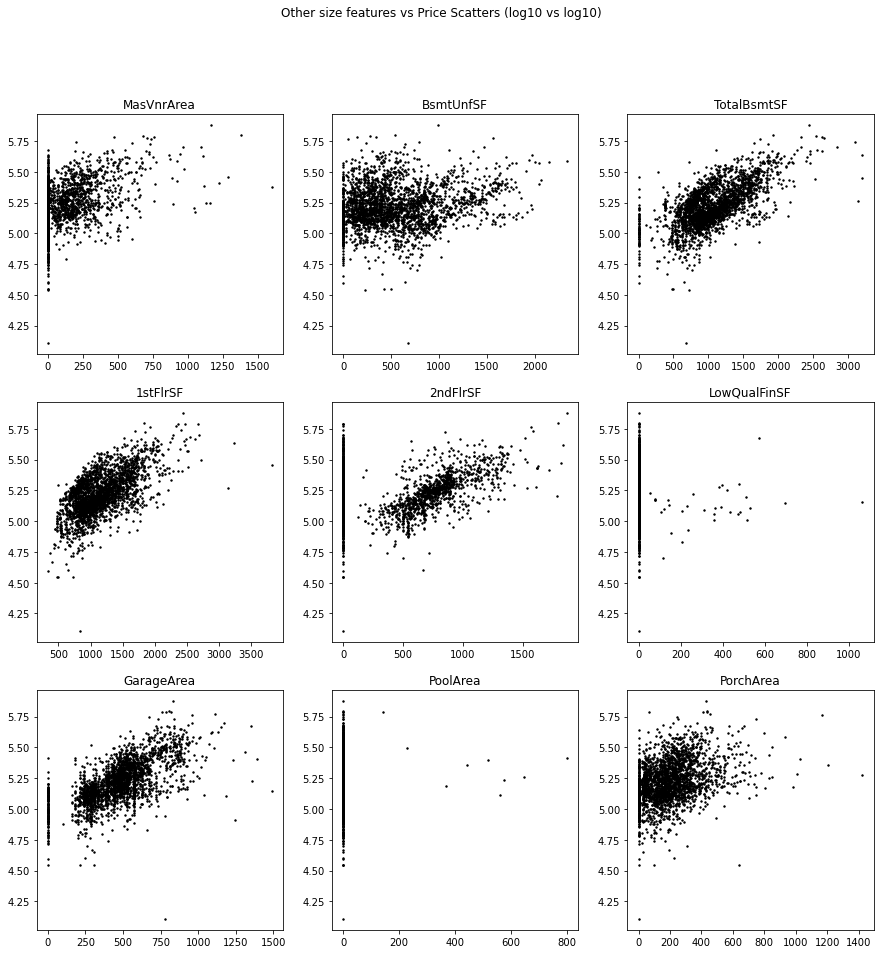

In [55]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

## 📉 Prepare for Multiple Regression

In [96]:
X = data[['GarageCars', 'BsmtQual','Foundation', 'PavedDrive', 'AllBath', 'TotRmsAbvGrd', 
         'Fireplaces', 'HeatingQC','Neighborhood', 'YearBuilt', 'OverallQual']]

In [97]:
X = X.join(size_related[['1stFlrSF','2ndFlrSF','GarageArea','PorchArea']],on='PID')

In [98]:
X_dum = pd.get_dummies(X, drop_first=True)

In [99]:
X_dum.isna().sum(axis=0).sum()

0

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.25)

In [70]:
lasso = Lasso(normalize=True)

In [71]:
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.8528498103249162

In [90]:
#try different alphas
alphas = np.linspace(0.00001,0.005,400)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, np.log10(y_train)))
    R2_test.append(lasso.score(X_test, np.log10(y_test)))

In [91]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,GarageCars,AllBath,TotRmsAbvGrd,Fireplaces,YearBuilt,OverallQual,1stFlrSF,2ndFlrSF,GarageArea,PorchArea,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,PavedDrive_P,PavedDrive_Y,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0.000010,0.005507,0.017936,0.000000,0.015142,0.000497,0.039522,0.000133,0.000081,0.000061,0.000063,-0.015295,-0.003959,-0.0,-0.0,0.017305,0.016623,-0.041596,0.0,0.0,0.018899,0.032911,-0.046142,-0.005045,0.0,-0.025936,-0.037240,-0.076397,-0.003681,0.041557,0.008247,0.056718,-0.018831,0.00107,-0.0,0.213292,-0.052850,-0.033142,-0.081428,0.007650,-0.0,-0.028921,-0.008826,0.027660,0.033110,-0.022224,-0.029194,0.003829,-0.006833,0.006107,0.030261,0.030371,0.033899
0.000023,0.004637,0.018280,0.000491,0.015226,0.000563,0.040065,0.000132,0.000077,0.000066,0.000062,-0.013253,-0.000906,-0.0,0.0,0.011031,0.011084,-0.043228,0.0,-0.0,0.012253,0.030589,-0.042720,-0.002939,0.0,-0.023920,-0.032466,-0.069328,-0.000572,0.035997,0.002684,0.053849,-0.016690,-0.00000,-0.0,0.184786,-0.049148,-0.010590,-0.076284,0.003102,0.0,-0.025510,-0.008211,0.021826,0.026246,-0.019778,-0.024655,0.001297,-0.007445,0.000000,0.022142,0.022540,0.024802


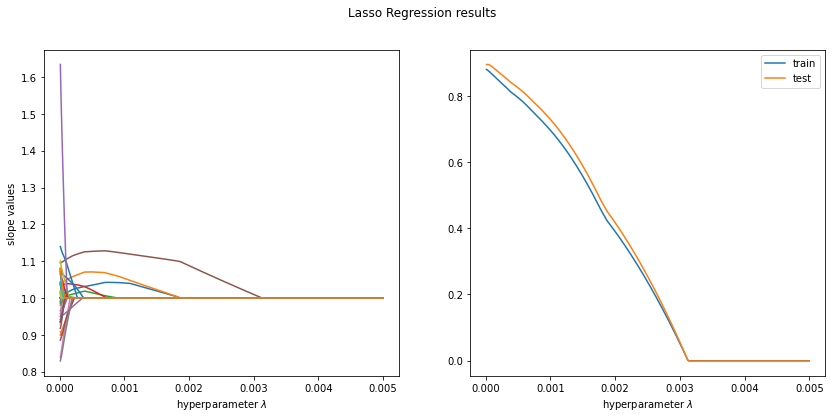

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

## 🌲 Prepare for RandomForest

In [112]:
from sklearn import ensemble
forest = ensemble.RandomForestRegressor()

In [131]:
forest.set_params(n_estimators=50, random_state=42, max_features=10)
forest.fit(X_train, y_train)
print("The training r2: %.5f" %(forest.score(X_train, y_train)))
print("The test     r2: %.5f" %(forest.score(X_test, y_test)))

The training r2: 0.98256
The test     r2: 0.87067


## Bad overfit and test error?

In [122]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 10,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [114]:
from sklearn.model_selection import GridSearchCV

In [123]:
np.linspace(start=6, stop=30, num=13, dtype=int)

array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [125]:
grid_para_forest = [{
    "max_depth": np.linspace(start=6, stop=30, num=13, dtype=int),
    "min_samples_split": np.linspace(start=6, stop=30, num=13, dtype=int)}]
gs_forest = GridSearchCV(forest, grid_para_forest, scoring='r2', cv=5, n_jobs=-1)
%time gs_forest.fit(X_train, y_train)

Wall time: 36.2 s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=10, n_estimators=50,
                                             random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'min_samples_split': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

In [126]:
gs_forest.best_params_

{'max_depth': 28, 'min_samples_split': 6}

In [132]:
print("The training r2: %.5f" % (gs_forest.score(X_train, y_train)))
print("The test     r2: %.5f" % (gs_forest.score(X_test, y_test)))

The training r2: 0.96319
The test     r2: 0.87293


In [130]:
pd.DataFrame({'Feat':X_train.columns,'Importance':gs_forest.best_estimator_.feature_importances_}).\
sort_values(by='Importance', ascending=False)

,Feat,Importance
5,OverallQual,0.224694
4,YearBuilt,0.130295
6,1stFlrSF,0.128894
1,AllBath,0.090436
0,GarageCars,0.087673
8,GarageArea,0.087497
7,2ndFlrSF,0.040350
3,Fireplaces,0.036176
2,TotRmsAbvGrd,0.029891
9,PorchArea,0.029591
